In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Выбран ряд AirQuality. В нем данные по замерам различных параметров воздуха (содержание примесей, температура, и т.д.).

In [2]:
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',', na_values=-200)
df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)

In [3]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
df.dropna(how='all', inplace=True)

Каждое вещество измеряется двумя датчиками, поэтому эти показания предположительно зависимы.

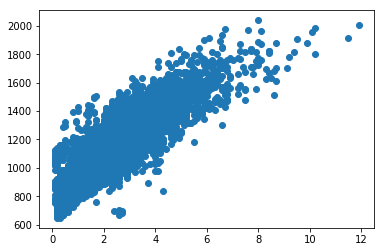

In [5]:
plt.scatter(df['CO(GT)'], df['PT08.S1(CO)'])

In [95]:
df_c = df.loc[:, ['CO(GT)', 'PT08.S1(CO)']].dropna()
np.corrcoef(df_c['CO(GT)'], df_c['PT08.S1(CO)'],)

array([[1.        , 0.87928834],
       [0.87928834, 1.        ]])

Создадим один признак времени

In [7]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'))

Оставим для исследования содержание веществ и температуру для пресказания

In [8]:
df1 = df.loc[:, ['datetime', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'T']].dropna()
df1['year'] = df1['datetime'].dt.year

Некоторые значения отсутствуют, удалим их

In [9]:
df1.shape

(8991, 7)

In [10]:
(9357-8991)/9357

0.0391151009939083

Всего удалено около 4% наблюдений, что приемлемо

In [11]:
df1.set_index(df1['datetime'], inplace=True)
df1.sort_index(inplace=True)

Отобразим зависимость температуры от времени

Text(0, 0.5, 'T')

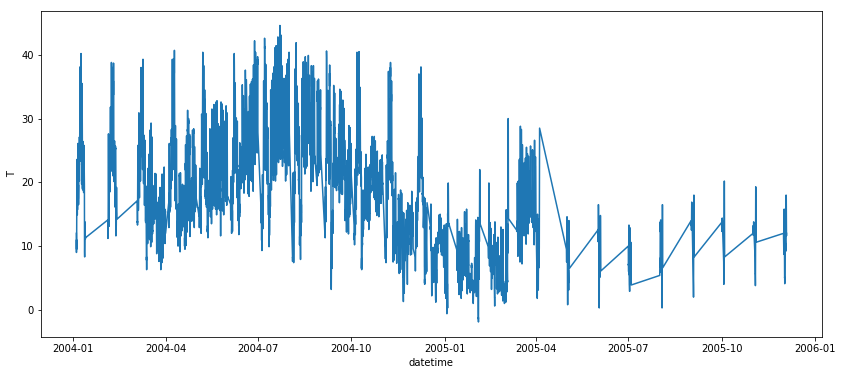

In [12]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'])
plt.xlabel('datetime')
plt.ylabel('T')

Видно, что значения сильно колеблются. Посмотрим на средние значения.

Отобразим средние значения за разные периоды

Text(0.5, 1.0, 'Average Temperature over day')

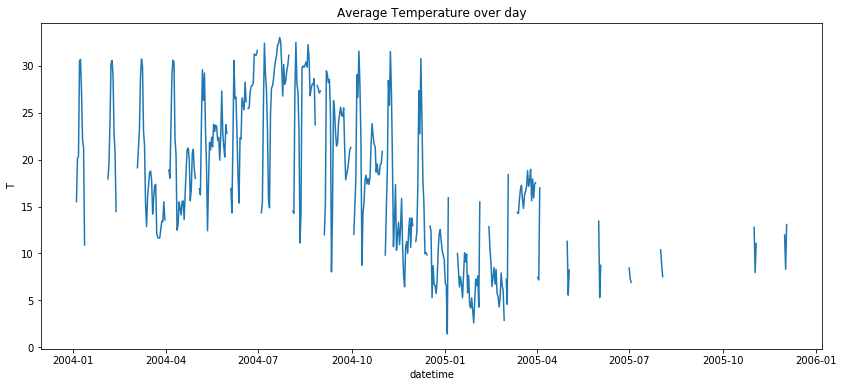

In [13]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'].resample('d').mean())
plt.xlabel('datetime')
plt.ylabel('T')
plt.title('Average Temperature over day')

Text(0.5, 1.0, 'Average Temperature over week')

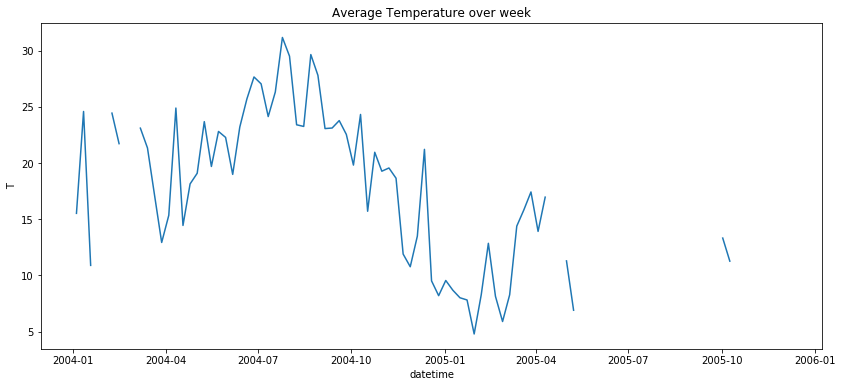

In [14]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'].resample('w').mean())
plt.xlabel('datetime')
plt.ylabel('T')
plt.title('Average Temperature over week')

Text(0.5, 1.0, 'Average Temperature over month')

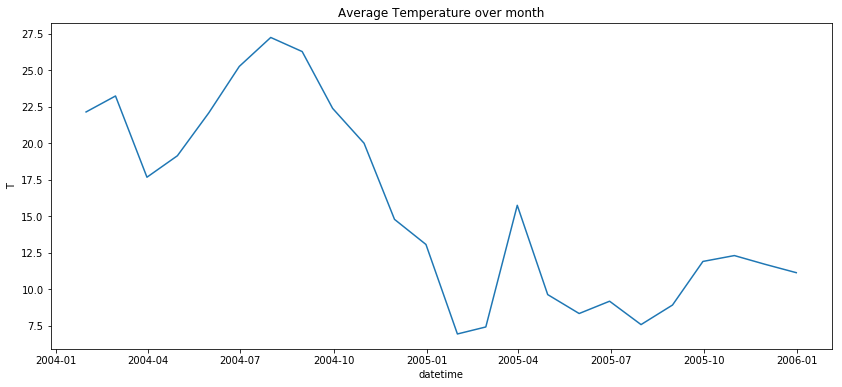

In [15]:
plt.figure(figsize=(14,6))
plt.plot(df1['T'].resample('m').mean())
plt.xlabel('datetime')
plt.ylabel('T')
plt.title('Average Temperature over month')

Температура снижается в 2005 году, отобразим значения за разные года

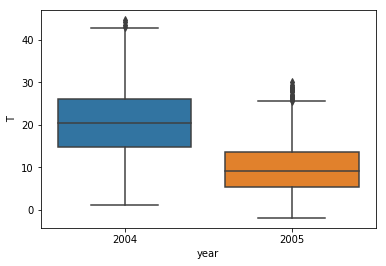

In [16]:
import seaborn as sns 

sns.boxplot(x="year", y="T", data=df1)

In [17]:
df_c = df.loc[:, ['CO(GT)', 'PT08.S1(CO)']].dropna()
np.corrcoef(df_c['CO(GT)'], df_c['PT08.S1(CO)'],)

array([[1.        , 0.87928834],
       [0.87928834, 1.        ]])

Построим модель

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
C:\Users\Zhenya\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Zhenya\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Zhenya\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Zhenya\AppData

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Отдельно напишем функции для создания входной и выходной переменных модели

In [71]:
def create_x(data, look_back=1):
    X = []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), :]
        X.append(a)
    return np.array(X)

In [46]:
def create_y(data, look_back=1):
    Y = []
    for i in range(len(data)-look_back-1):
        Y.append(data[i + look_back])
    return np.array(Y)

Подготовим данные

In [88]:
data = df1.loc[:, ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'T']]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
X = data[:, :4]
#X = np.reshape(X, (-1, 4))
#scaler = MinMaxScaler(feature_range=(0, 1))
#X = scaler.fit_transform(X)
y = data[:, 4]
#y = np.reshape(X, (-1, 1))
#scaler = MinMaxScaler(feature_range=(0, 1))
#y = scaler.fit_transform(y)

In [ ]:
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Выделим обучающую и тестовую выборку

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [90]:
look_back = 30
X_train = create_x(X_train, look_back)
Y_train = create_y(y_train, look_back)
X_test = create_x(X_test, look_back)
Y_test = create_y(y_test, look_back)

In [91]:
X_train.shape

(5992, 30, 4)

In [142]:
dataset = df1['T'].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [144]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [92]:
X_train.shape

(5992, 30, 4)

In [93]:
Y_train.shape

(5992,)

In [94]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1],  X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 5992 samples, validate on 2937 samples
Epoch 1/30
5992/5992 [==============================] - 2s 361us/step - loss: 0.0448 - val_loss: 0.0362
Epoch 2/30
5992/5992 [==============================] - 2s 257us/step - loss: 0.0381 - val_loss: 0.0358
Epoch 3/30
5992/5992 [==============================] - 3s 422us/step - loss: 0.0375 - val_loss: 0.0356
Epoch 4/30
5992/5992 [==============================] - 2s 345us/step - loss: 0.0377 - val_loss: 0.0356
Epoch 5/30
5992/5992 [==============================] - 3s 439us/step - loss: 0.0372 - val_loss: 0.0356
Epoch 6/30
5992/5992 [==============================] - 3s 470us/step - loss: 0.0371 - val_loss: 0.0356
Epoch 7/30
5992/5992 [==============================] - 3s 467us/step - loss: 0.0372 - val_loss: 0.0356
Epoch 8/30
5992/5992 [==============================] - 3s 571us/step - loss: 0.0371 - val_loss: 0.0356
Epoch 9/30
5992/5992 [==============================] - 3s 543us/step - loss: 0.0371 - val_loss: 0.0356
Epoch 10/30
5992

In [96]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

ValueError: non-broadcastable output operand with shape (5992,1) doesn't match the broadcast shape (5992,5)

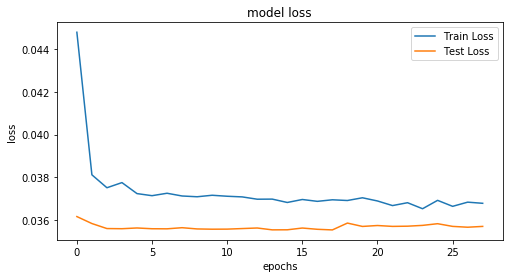

In [97]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

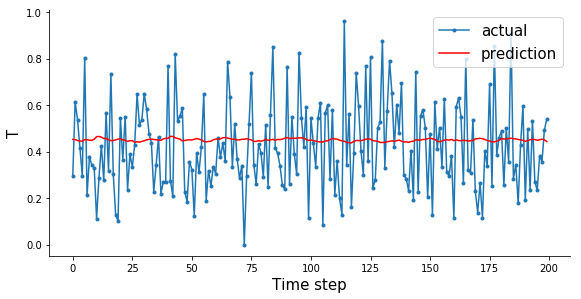

In [100]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('T', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [110]:
a.shape

(16, 9357)

In [53]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005,10.00.00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,04/04/2005,14.00.00,2.2,1071.0,NaN,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


In [52]:
df.shape

(9357, 15)

(array([ 117.,  901., 1335., 1817., 1611., 1471.,  881.,  487.,  310.,
          61.]),
 array([-1.9 ,  2.75,  7.4 , 12.05, 16.7 , 21.35, 26.  , 30.65, 35.3 ,
        39.95, 44.6 ]),
 <a list of 10 Patch objects>)

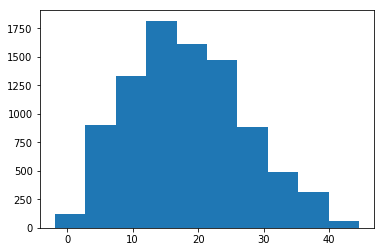

In [72]:
plt.hist(df1['T'])

In [74]:
df1['T'].plot
plt.show()

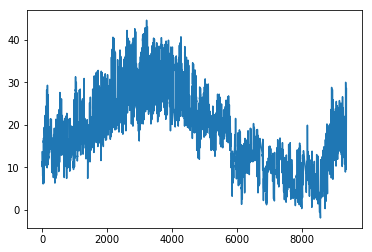

In [78]:
plt.plot(df1['T'])

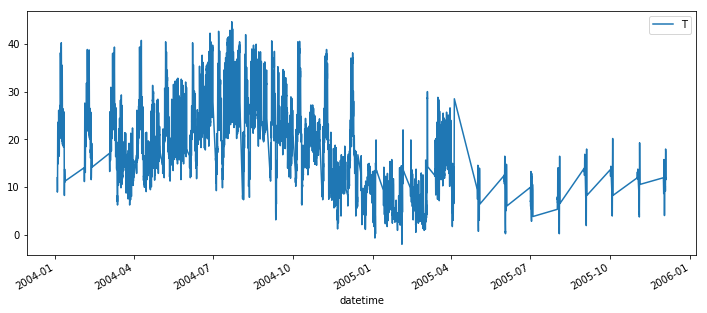

In [76]:
df2=df1.loc[:,['datetime','T']]
df2.set_index('datetime',inplace=True)
df2.plot(figsize=(12,5))
plt.show();

In [38]:
df.dropna(inplace=True)

In [39]:
df.shape

(827, 15)

In [23]:
df[df['T'] < 0]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,datetime
524,01/04/2004,14.00.00,1.7,-200.0,222.0,-200.0,-200.0,99.0,-200.0,72.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-01-04 14:00:00
525,01/04/2004,15.00.00,1.9,-200.0,197.0,-200.0,-200.0,108.0,-200.0,81.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-01-04 15:00:00
526,01/04/2004,16.00.00,2.3,-200.0,319.0,-200.0,-200.0,131.0,-200.0,93.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-01-04 16:00:00
701,08/04/2004,23.00.00,2.0,-200.0,137.0,-200.0,-200.0,129.0,-200.0,106.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-08-04 23:00:00
702,09/04/2004,00.00.00,2.4,-200.0,189.0,-200.0,-200.0,154.0,-200.0,109.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-09-04 00:00:00
703,09/04/2004,01.00.00,1.8,-200.0,159.0,-200.0,-200.0,118.0,-200.0,97.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-09-04 01:00:00
704,09/04/2004,02.00.00,1.0,-200.0,80.0,-200.0,-200.0,69.0,-200.0,83.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-09-04 02:00:00
705,09/04/2004,03.00.00,1.0,-200.0,66.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-09-04 03:00:00
706,09/04/2004,04.00.00,1.0,-200.0,87.0,-200.0,-200.0,97.0,-200.0,79.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-09-04 04:00:00
707,09/04/2004,05.00.00,0.9,-200.0,79.0,-200.0,-200.0,145.0,-200.0,84.0,-200.0,-200.0,-200.0,-200.0,-200.0000,NaN,NaN,2004-09-04 05:00:00


In [26]:
df.shape

(9471, 18)

In [27]:
366/9471

0.03864428254672157

In [13]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'))

In [17]:
df1 = df.loc[:, ['datetime', 'T']]
df1.plot()

ValueError: view limit minimum -36824.19791666667 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001914B76B620> (for post_execute):


ValueError: view limit minimum -36824.19791666667 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36824.19791666667 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units